# Testing scaled t-SNE on data by Hrvatin et al. 2018


In this notebook we will show the difference between the vanilla t-SNE and the scaled conditional probability t-SNE on an example of single cell expression (scRNAseq) data collected by [Hrvatin et al. 2018](https://www.nature.com/articles/s41593-017-0029-5) taken from the mouse visual cortex samples.

The premise is to show that the vanilla t-SNE distorts input data expandin / shrinking clusters depending on the number of contained data points. If local data variances are of intrest to the data analyst, this is not a desired property of a data visualization tool. In other words the intra-cluster pairwise distances between observations cannot be compared between clusters, as the cluster sizes only reflect the sampling density (number of memberobservations).

First, load necessary libraries and download and unzip the data.

In [2]:
import os, sys, mkl, time, pickle
nthreads = 20                                  # limit the number of threads for all operations
os.environ["OMP_NUM_THREADS"] = str(nthreads)  # must be set before loading numpy
mkl.set_num_threads(nthreads)
import numpy as np
import pandas as pd
import multiprocessing as mp

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.titlesize'] = 24
mpl.rcParams['axes.titlesize']   = 20
mpl.rcParams['axes.labelsize']   = 20
mpl.rcParams['xtick.labelsize']  = 20
mpl.rcParams['ytick.labelsize']  = 20


# Custom pyscripts
maindir = '/home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE'
os.chdir(maindir)
sys.path.insert(0, maindir)
from diffusion_tsne import diffusion_tsne
from plotting import *
from generate_data import *
from utils import *
from metrics import *

%load_ext autoreload
%autoreload 2

MACHINE_EPSILON = np.finfo(np.double).eps

# Load preprocessed data
celltype = pd.read_pickle("data/hrvatin2018/hrvatin_cell_info.pkl")
dfsub  = pd.read_pickle("data/hrvatin2018/hrvatin_filtr_genes_sub.pkl")
dfsub.shape

(48266, 19155)

Then, we download the data file GSE102827_merged_all_raw.csv.gz from:

https://www.dropbox.com/sh/ri6fa3mbhvgapqk/AACz-gmkCDYojbQkrXmnA1f9a/GSE102827_merged_all_raw.csv.gz

and the associated cell type labels at:
https://www.dropbox.com/sh/ri6fa3mbhvgapqk/AACwWhI3dq6cEZXyeGSJIUlya/hrvatin_celltypes.csv?dl=0

The data is maintained by autors of SAVER, [Huang et al. 2018](https://www.nature.com/articles/s41592-018-0033-z) and stored in the following data folder:

https://www.dropbox.com/sh/ri6fa3mbhvgapqk/AADwOzHfiCcLSqYnX9CTyd7_a?dl=0

In [2]:
%%bash
pwd
if [ -f ./data/hrvatin2018/GSE102827_merged_all_raw.csv ]; then
    echo "File already downloaded";
else 
    mkdir ./data/hrvatin2018
    cd ./data/hrvatin2018
    wget https://www.dropbox.com/sh/ri6fa3mbhvgapqk/AACwWhI3dq6cEZXyeGSJIUlya/hrvatin_celltypes.csv
    wget https://www.dropbox.com/sh/ri6fa3mbhvgapqk/AACz-gmkCDYojbQkrXmnA1f9a/GSE102827_merged_all_raw.csv.gz;
    gunzip GSE102827_merged_all_raw.csv.gz;
fi

/home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE
File already downloaded


## Load data

In [8]:
filename = "./data/hrvatin2018/GSE102827_merged_all_raw.csv"   # large file: 3.1GB
dftest = pd.read_csv(filename, nrows = 5, index_col=0)
dtypes = {}
for name in dftest.columns:
    dtypes[name] = 'uint32'
dtypes['Unnamed'] = 'object'
print(dftest.shape)

(5, 65539)


In [9]:
dftest.iloc[0:5, 1:5]

,x2_35_0_bc0014,x2_35_0_bc0016,x2_35_0_bc0017,x2_35_0_bc0018
0610007P14Rik,0,1,0,0
0610009B22Rik,1,0,1,0
0610009E02Rik,0,0,0,0
0610009L18Rik,0,0,0,0
0610009O20Rik,1,0,0,0


In [10]:
# Load data in chunks and filter the the genes with too sparse expression
# This takes a while, as pandas.read_csv is slow for datasets with many columns
count_thresh  =  0.00003; prev_thresh = 3    # Filtering thresholds
chunk_list = []; chunksize = 1000; 
i = 0; nrow_raw = 0; 
start = time.time(); t0 = time.time()
for chunk in pd.read_csv(filename, chunksize=chunksize, iterator=True, index_col=0, dtype=dtypes):
    chunk = chunk.rename(columns={c: c.replace(' ', '') for c in dftest.columns}) 
    nrow_raw += chunk.shape[0]
    # Filter out genes with expression less than 0.00003
    chunk =chunk[chunk.mean(axis = 1) >= count_thresh] 
    # Filter out genes with non-zero expression in less than 4 cells
    chunk = chunk[chunk.ne(0).sum(1).gt(prev_thresh)]
    chunk_list.append(chunk)
    if (i*chunksize) % 1000 == 0:
        print("Processed: %d rows in %f sec...\n" %((i+1)*chunksize, time.time() - t0))
        t0 = time.time()
    i += 1
df = pd.concat(chunk_list)
end = time.time()
print("Read (%d x %d) table with pandas in %f sec. After filtering %d rows left.\n"
      %(nrow_raw, df.shape[1], end - start, df.shape[0]))
df.transpose().to_pickle("data/hrvatin2018/hrvatin_filtr_genes_all_samples.pkl")
## Read (25187 x 65539) table with pandas in 5934.982001 sec. After filtering 19155 rows left.

Read (25187 x 65539) table with pandas in 5934.982001 sec. After filtering 19155 rows left.



In [16]:
print(df.transpose().shape)
df.transpose().iloc[0:5, 1:5]

(65539, 19155)


,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik
x2_35_0_bc0013,1,0,0,0
x2_35_0_bc0014,1,0,0,1
x2_35_0_bc0016,0,0,0,0
x2_35_0_bc0017,1,0,0,0
x2_35_0_bc0018,0,0,0,0


Now, load the cell information including the know cell type labels.

In [3]:
celltype = pd.read_csv("./data/hrvatin2018/hrvatin_celltypes.csv", index_col = 0)
celltype['cellID'] = celltype.index
celltype = celltype[pd.notnull(celltype['celltype'])]
celltype.shape
celltype['cellclass'] = celltype['subtype'].fillna(celltype['celltype'])
celltype.shape
celltype.to_pickle("data/hrvatin2018/hrvatin_cell_info.pkl")

In [22]:
celltype.head()

,stim,sample,maintype,celltype,subtype,cellID,cellclass
x2_35_0_bc0013,0h,B1_1_0h,Excitatory,ExcL4,ExcL4_3,x2_35_0_bc0013,ExcL4_3
x2_35_0_bc0014,0h,B1_1_0h,Excitatory,ExcL5_3,NaN,x2_35_0_bc0014,ExcL5_3
x2_35_0_bc0016,0h,B1_1_0h,Excitatory,ExcL5_2,NaN,x2_35_0_bc0016,ExcL5_2
x2_35_0_bc0017,0h,B1_1_0h,Excitatory,ExcL6,NaN,x2_35_0_bc0017,ExcL6
x2_35_0_bc0018,0h,B1_1_0h,Excitatory,ExcL5_3,NaN,x2_35_0_bc0018,ExcL5_3


In [5]:
crosstab = pd.crosstab(celltype["maintype"], columns = "count")
crosstab

col_0,count
maintype,
Astrocytes,7039
Endothelial_SmoothMuscle,4071
Excitatory,14287
Interneurons,936
Macrophages,537
Microglia,10158
Mural,782
Oligodendrocytes,10456


Next, remove all the cells with unknown labels for the cell type.

In [24]:
# Filter to only keep cells with cell type information
dfsub  = df[list(celltype["cellID"])]
dfsub = dfsub.transpose()
dfsub.to_pickle("data/hrvatin2018/hrvatin_filtr_genes_sub.pkl")
dfsub.shape

# PCA

In [32]:
# Process data: normalize and variance stabilize
X0 = dfsub.values
# Normalize to equal
totalUMIPerCell = X0.sum(axis = 1)
Xnorm = X0 / totalUMIPerCell[:, np.newaxis]
Xnorm = np.log( 10e3 * Xnorm + 1)

# center the columns
Xnorm_colmean = Xnorm.mean(axis = 0)
Xnorm_cntr = Xnorm - Xnorm_colmean[np.newaxis, :]

In [61]:
# Do randomized PCA/SVD and keep 50 dimensions
from sklearn.utils.extmath import randomized_svd
nPC = 50; seed = int(time.time())
U, s, VT = randomized_svd(Xnorm_cntr,n_components=nPC,random_state=seed)
X50PCs = np.dot(U, np.diag(s))
X50PCs.shape

(48266, 50)

In [62]:
s.min()

244.73676079413508

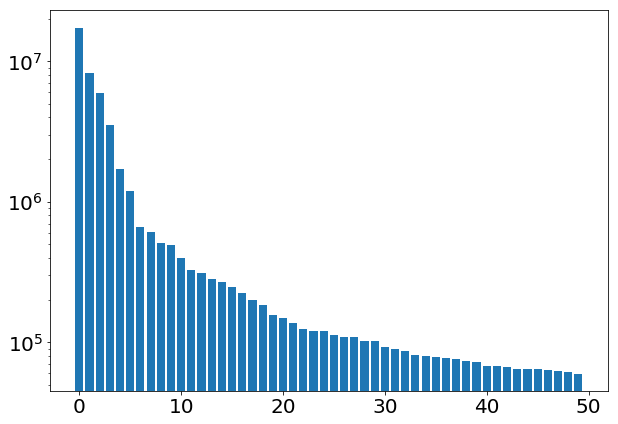

In [64]:
plt.figure(figsize = (10, 7))
plt.bar(range(nPC), s**2, log = True)
var_exp = np.round(100*s**2/np.sum(s**2))

Text(0, 0.5, 'PC2 [18.0 %]')

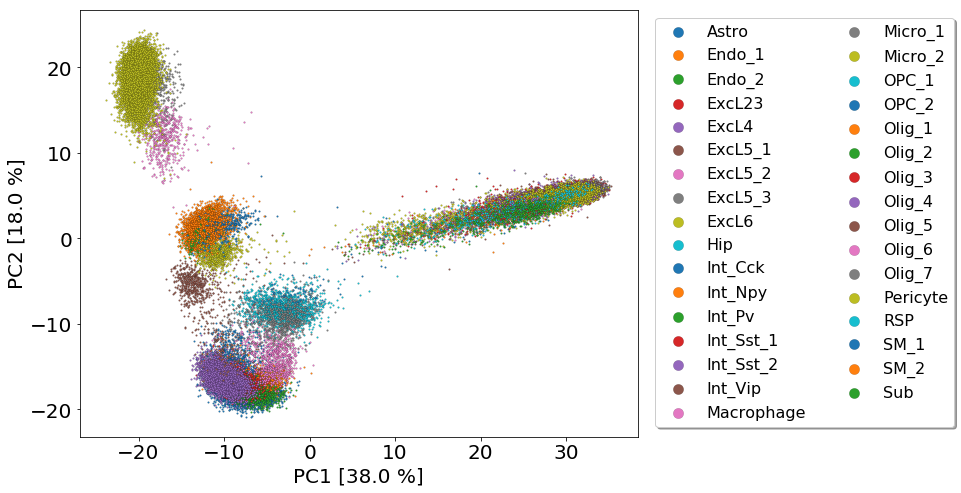

In [91]:
plot2D(X50PCs[:, 0:2], label=celltype["celltype"], s=3, figsize = (10, 10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 1), 
    shadow=True, ncol=2)
plt.axes().set_aspect(aspect=1)
plt.xlabel("PC1 [%4.1f %%]" %var_exp[0])
plt.ylabel("PC2 [%4.1f %%]" %var_exp[1])

Text(0, 0.5, 'PC2 [18.0 %]')

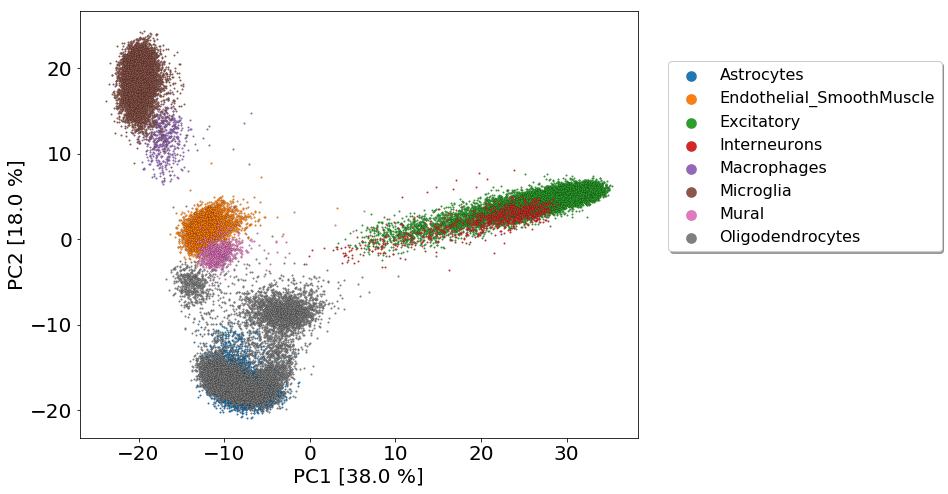

In [92]:
plot2D(X50PCs[:, 0:2], label=celltype["maintype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=1)
plt.axes().set_aspect(aspect=1)
plt.xlabel("PC1 [%4.1f %%]" %var_exp[0])
plt.ylabel("PC2 [%4.1f %%]" %var_exp[1])

Text(0, 0.5, 'PC3 [13.0 %]')

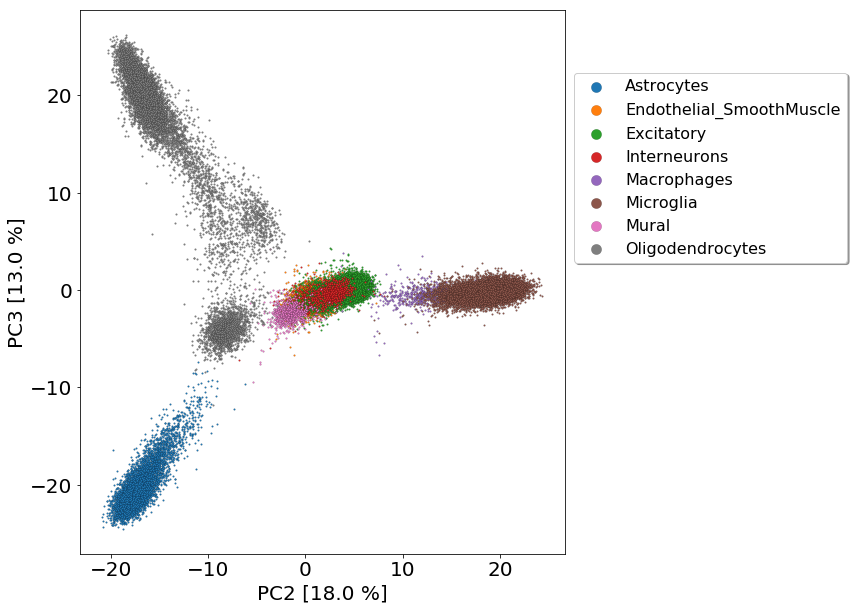

In [93]:
plot2D(X50PCs[:, 1:3], label=celltype["maintype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=1)
plt.axes().set_aspect(aspect=1)
plt.xlabel("PC2 [%4.1f %%]" %var_exp[1])
plt.ylabel("PC3 [%4.1f %%]" %var_exp[2])

# t-SNE

In [33]:
cell_labs = celltype["celltype"]

In [29]:
all(celltype.cellID == dfsub.index)

True

In [4]:
start = time.time()
Y_tsne_p100 = diffusion_tsne(
    X50PCs, perplexity=100, seed=42, scale_probs = False,
    nthreads=nthreads, load_affinities="save")
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
betas0 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees0 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist0 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))

Using compiled binary file: /bin/diffusion_tsne
t-SNE embedding in 253.701563 sec


In [101]:
crosstab = pd.crosstab(celltype["maintype"], celltype["celltype"])
crosstab

celltype,Astro,Endo_1,Endo_2,ExcL23,ExcL4,ExcL5_1,ExcL5_2,ExcL5_3,ExcL6,Hip,...,Olig_3,Olig_4,Olig_5,Olig_6,Olig_7,Pericyte,RSP,SM_1,SM_2,Sub
maintype,,,,,,,,,,,,,,,,,,,,,
Astrocytes,7039,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Endothelial_SmoothMuscle,0,3327,123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,323,298,0
Excitatory,0,0,0,2963,3198,1976,410,1407,3276,137,...,0,0,0,0,0,0,420,0,0,500
Interneurons,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Macrophages,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Microglia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,782,0,0,0,0
Oligodendrocytes,0,0,0,0,0,0,0,0,0,0,...,846,4047,747,786,630,0,0,0,0,0


(-40.45939744467247, 37.68306378483055, -39.028235975200296, 36.18811619971703)

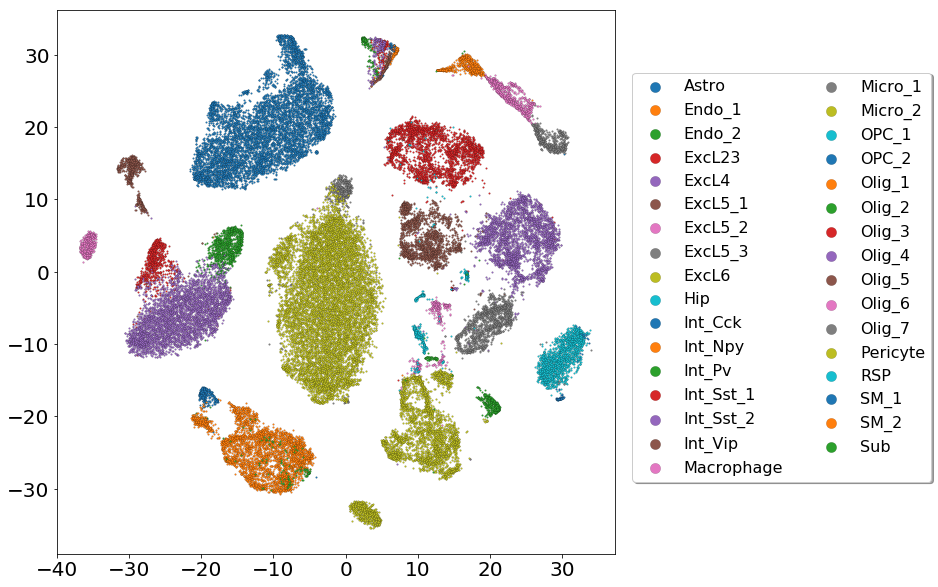

In [8]:
plot2D(Y_tsne_p100, label=celltype["celltype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=2)
plt.axis('equal')

(-42.249803671121306,
 38.308839219092214,
 -39.203648097279185,
 36.52601310322946)

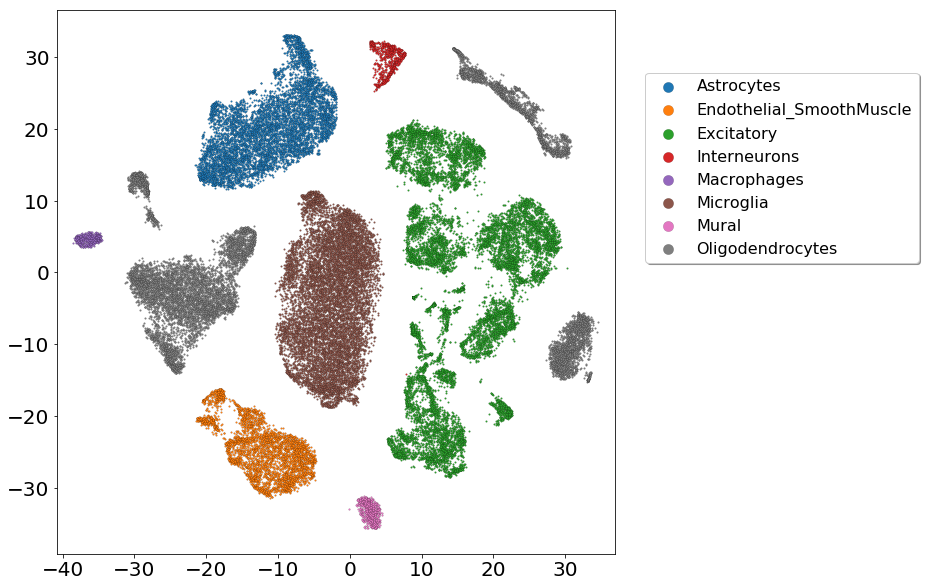

In [92]:
plot2D(Y_tsne_p100, label=celltype["maintype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=1)
plt.axis('equal')

(-42.155192167605534, 38.18503297832611, -39.08993553647247, 36.52374719456607)

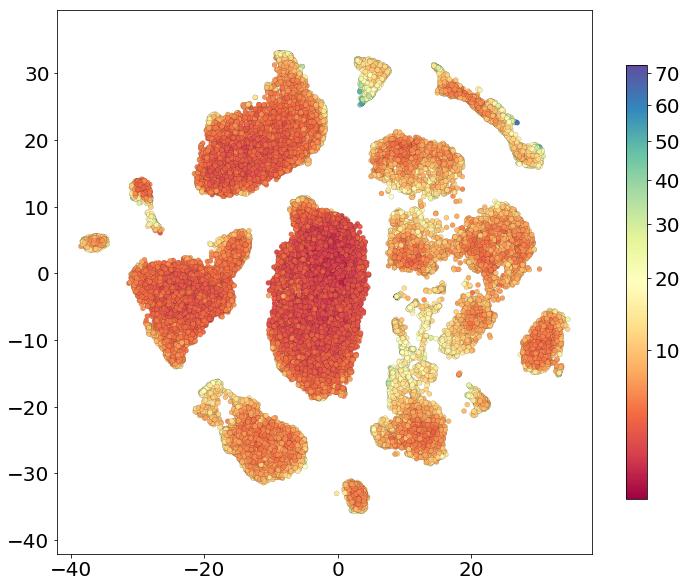

In [60]:
plot2D(Y_tsne_p100, label= 1/(2*betas0), s=25, figsize=(12,10),
      norm=mpl.colors.PowerNorm(gamma=1./2.))
plt.axis('equal')

# Scaled t-SNE

In [6]:
start = time.time()
Y_scaletsne_p100 = diffusion_tsne(
    X50PCs, perplexity=100, seed=42, scale_probs = True,
    nthreads=nthreads, load_affinities="save")
end = time.time()
print('Scale t-SNE embedding in %f sec' %(end-start))
betas1 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees1 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist1 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))

Using compiled binary file: /bin/diffusion_tsne
Scale t-SNE embedding in 246.556408 sec


In [90]:
np.unique(celltype.maintype).shape

(8,)

(-41.20207569750056,
 36.82972267330279,
 -40.112513266589346,
 40.066185416803044)

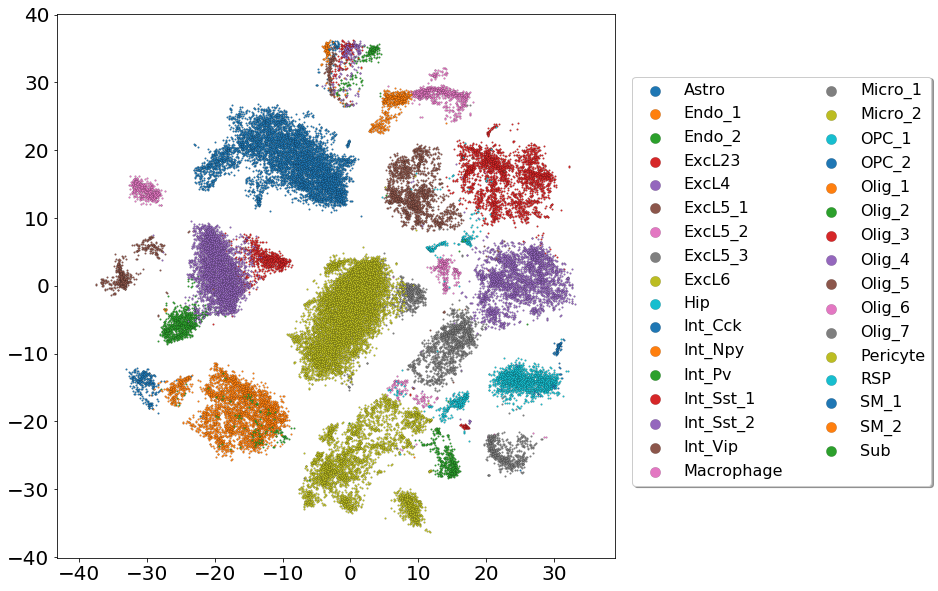

In [9]:
plot2D(Y_scaletsne_p100, label=celltype["celltype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=2)
plt.axis('equal')

(-40.88541604791693, 36.659335523445264, -39.57203021545855, 40.18949267262314)

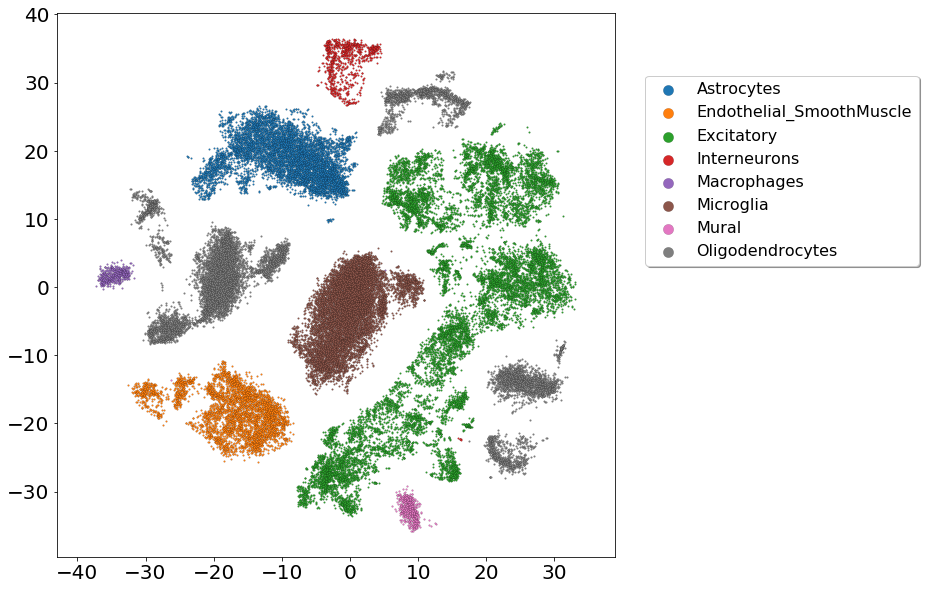

In [94]:
plot2D(Y_scaletsne_p100, label=celltype["maintype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=1)
plt.axis('equal')

(-40.768737138115725, 36.59739269743187, -39.44261559596777, 40.07751561429784)

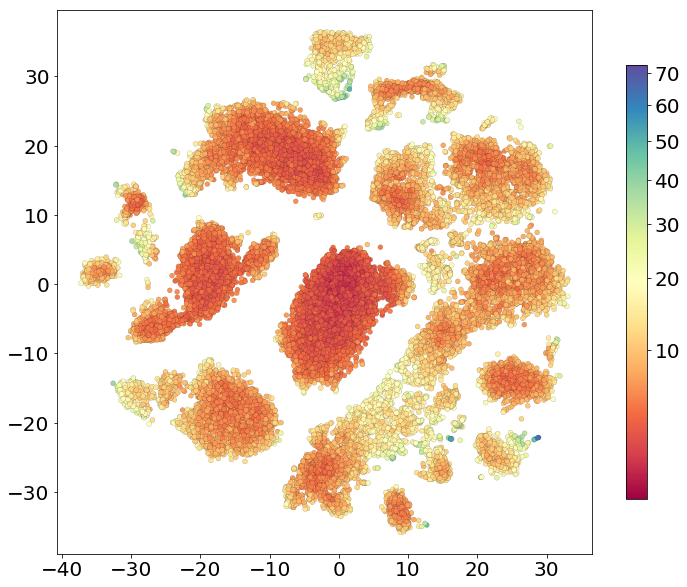

In [64]:
plot2D(Y_scaletsne_p100, label= 1/(2*betas1), s=25, figsize=(12,10),
      norm=mpl.colors.PowerNorm(gamma=1./2.))
plt.axis('equal')

In [81]:
df1 = pd.DataFrame(Y_tsne_p100); df2 = pd.DataFrame(Y_scaletsne_p100)
df1['celltype'] = df2['celltype'] = list(cell_labs)
df1.columns = df2.columns = ["PC1", "PC2", "celltype"]
df1.head()

,PC1,PC2,celltype
0,24.015346,-1.277668,ExcL4
1,19.593820,-6.174672,ExcL5_3
2,13.818055,-6.154862,ExcL5_2
3,14.722571,-27.737873,ExcL6
4,19.528472,-5.915182,ExcL5_3


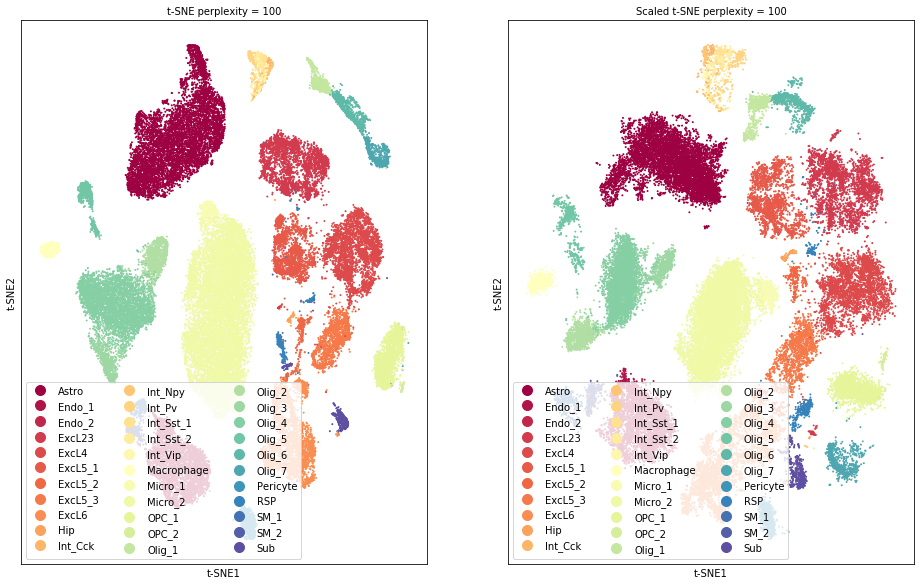

In [84]:
# Compare the two
import scprep
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 10))
scprep.plot.scatter2d(Y_tsne_p100, label_prefix="t-SNE", 
                      title="t-SNE perplexity = 100",fontsize=14, 
                      c=cell_labs, ticks=False, cmap='Spectral', ax=ax1)

scprep.plot.scatter2d(Y_scaletsne_p100, label_prefix="Scaled t-SNE", 
                      title="Scaled t-SNE perplexity = 100",fontsize=14,
                      c=cell_labs, ticks=False, cmap='Spectral', ax=ax2)


# UMAP

In [27]:
import umap
# in our implementation of FIt-SNE we use entropy = np.log(perplexity) whereas in
# umap one has entropy = np.log2(n_neigh) so we need to adjust:
# np.log(100) = np.log2(n_neigh) ==> n_neigh = 2**np.log(100)
# n_neigh [10-15] ==> perplexity [30-50]

H = np.log(100)
n_neigh = int(2**H)
print("n_neigh used: %d" %n_neigh)

start = time.time()
umap_p100 = umap.UMAP(n_neighbors=n_neigh)
Y_umap_p100_spec_init = umap_p100.fit_transform(X50PCs)
end = time.time()
print('UMAP embedding in %f sec' %(end-start))

n_neigh used: 24


/home/lanhuong/.local/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


UMAP embedding in 517.986668 sec


(-12.309857614264068,
 18.993431385841415,
 -12.49586364293117,
 14.233028738842126)

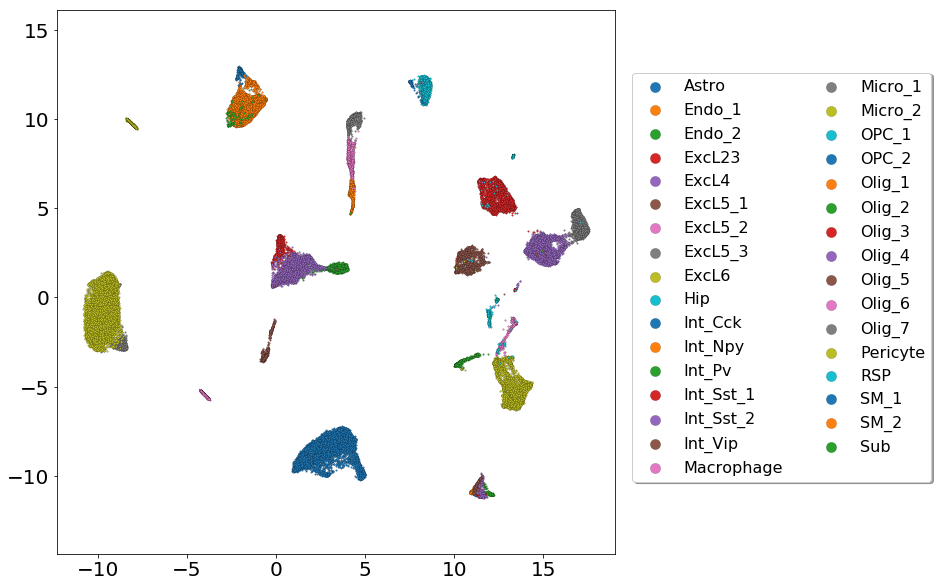

In [29]:
plot2D(Y_umap_p100_spec_init, label=celltype["celltype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=2)
plt.axis('equal')

(-12.30702013773417,
 18.971214372405644,
 -12.493037091414715,
 14.194699765369188)

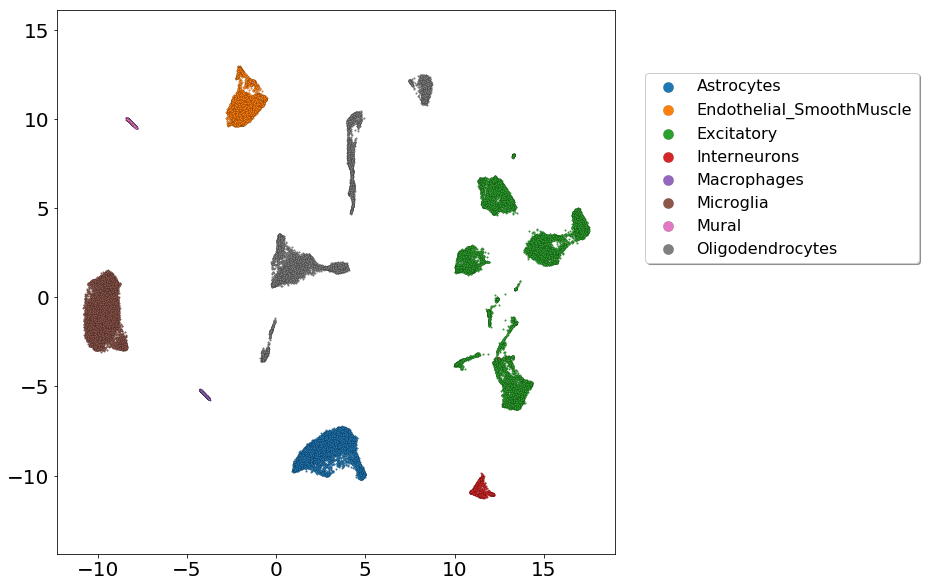

In [30]:
plot2D(Y_umap_p100_spec_init, label=celltype["maintype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=1)
plt.axis('equal')

In [24]:
start = time.time()
umap_p100_rinit = umap.UMAP(n_neighbors=n_neigh, init = "random")
Y_umap_p100 = umap_p100_rinit.fit_transform(X50PCs)
end = time.time()
print('UMAP embedding in %f sec' %(end-start))

UMAP embedding in 622.243788 sec


(-13.943893850349445,
 11.490773582719006,
 -18.009530719721926,
 14.619437727744847)

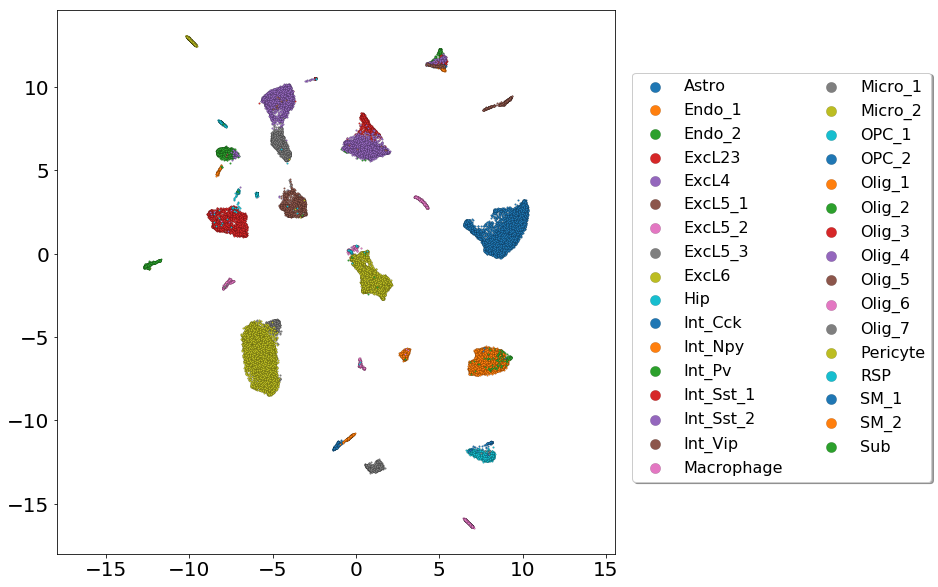

In [28]:
plot2D(Y_umap_p100, label=celltype["celltype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=2)
plt.axis('equal')

(-13.923953913885898,
 11.489824061935028,
 -18.009807579389275,
 14.619447608081007)

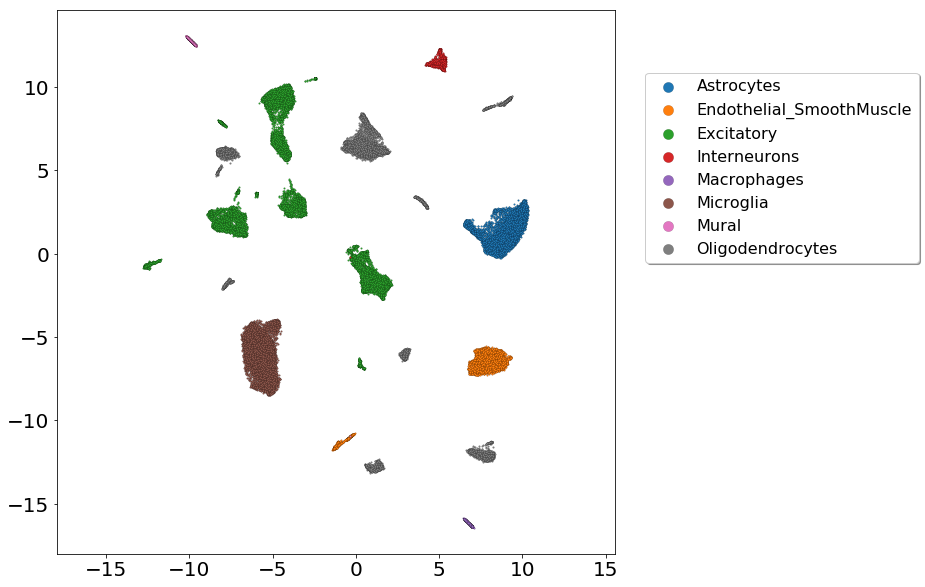

In [26]:
plot2D(Y_umap_p100, label=celltype["maintype"], s=3, figsize=(10,10))
plt.legend(
    fontsize=16, markerscale=6,
    loc='upper center', bbox_to_anchor=(1.3, 0.9), 
    shadow=True, ncol=1)
plt.axis('equal')

In [ ]:
H = np.log(500)
n_neigh = int(2**H)
print("n_neigh used: %d" %n_neigh)

In [96]:
np.exp(np.log2(100))

768.0510403855433